# Data Representativeness Walkthrough

### Introduction

Ok, so in this lesson we'll move through various techniques for checking a dataset.  And before we do so, just remember the problems that can occur if we don't do so.  Essentially, we may be looking for insights from a dataset that does not reflect the real world.  

That is, the data we are capturing may look very dissimilar from our missing data.  And so, we need to consider that before trying to say anything about the underlying population.

Ok, speech over, let's see move through some techniques for exploring our dataset. 

### Loading our data

Remember that our data involves SAT scores from NYC schools.

In [5]:
import pandas as pd
url = 'https://raw.githubusercontent.com/analytics-engineering-jigsaw/data-visualization/main/2-storytelling/1-what-to-focus-on/sat_scores.csv'
df = pd.read_csv(url, index_col = 0)

In [6]:
df[:2]

,dbn,name,num_test_takers,reading_avg,math_avg,writing_score,boro,total_students,graduation_rate,attendance_rate,college_career_rate
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,M,171,0.66,0.87,0.36
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,M,465,0.90,0.93,0.70


And we can clean up our data, and then group it by borough.

In [7]:
df['boro'].unique()

array(['M', 'X', 'K', 'Q', 'R'], dtype=object)

> We replace the borough information with the [original names](https://en.wikipedia.org/wiki/Boroughs_of_New_York_City).

In [8]:
keys = ['M', 'X', 'K', 'Q', 'R']
values = ['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']
dictionary = dict(zip(keys, values))
boro_updated = df['boro'].replace(dictionary)
df_updated = df.assign(boro = boro_updated)

> And then group by the borough.

In [35]:
avg_by_boro = df_updated.groupby('boro').mean(numeric_only = True)
avg_by_boro[['math_avg', 'reading_avg']].sort_values('math_avg', ascending = False)
# avg_by_boro

,math_avg,reading_avg
boro,,
Staten Island,472.500000,457.500000
Queens,450.650000,423.916667
Manhattan,442.886076,426.696203
Brooklyn,404.030612,391.255102
Bronx,394.000000,384.237500


Ok, so now let's move through some techniques for exploring how representative this data is.

### Exploring Missing Data

1. Missing Observations (Rows) of Data

Now one question, we may have is simply, do we have all of the data from each county.  Let's use value_counts to find out.

In [48]:
df_updated['boro'].value_counts()

Brooklyn         104
Manhattan         90
Bronx             87
Queens            65
Staten Island     10
Name: boro, dtype: int64

<AxesSubplot: >

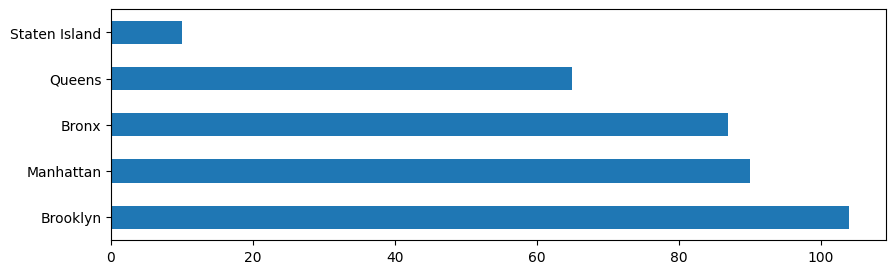

In [53]:
df_updated['boro'].value_counts().plot(kind = 'barh', figsize= (10, 3))

So we can see we have very few number of high schools in staten island -- but this doesn't necessarily mean the data is missing.

For that we can look at an [outside resource](https://high-schools.com/directory/ny/cities/staten-island/), and it looks like there are only 27 high schools in staten island, and 280 in brooklyn.  

* Test takers per school

Of course, even if we did have a large number of schools participating, that may not mean that we can lean on math SAT scores to draw too many conclusions about the math capability of the boro's students.  

What else should we consider?  Well we can also look at the percentage of students taking the test.  Here, we are pretty lucky to have both the `total_students` per school, and the `num_test_takers`.

In [62]:
pct_test_takers = df_updated['num_test_takers']/df_updated['total_students']
df_with_pct = df_updated.assign(pct_test_takers = pct_test_takers)

In [65]:
grouped_df_pct = df_with_pct.groupby('boro').mean(numeric_only = True)
grouped_df_pct['pct_test_takers']

boro
Bronx            0.146833
Brooklyn         0.168416
Manhattan        0.171484
Queens           0.153365
Staten Island    0.161102
Name: pct_test_takers, dtype: float64

Here, Manhattan does have a larger percentage of test takers -- but we'd have to explore further to see if this is likely to affect the results.

### Missing or incorrect values

Ok, so above, we looked for missing rows of data by just counting up the number of schools we had per row.  And we also looked at the percentage of students who took the in our reporting schools.

We should also look at our missing or incorrect values in the rows of data we have.  Here we'll see missing or incorrect values across our columns.

What columns should we focus on?  Well really any column can indicate poor data -- but the most important column is really the *target*.  By the target we mean the metric that we are trying to predict - or is of interest.  

So here, the most interesting column is our SAT score data, as opposed to say the percentage who are college seeking.

* Na values

We can count up missing values by looking at na values:

In [69]:
df_with_pct.isna()[:3]

,dbn,name,num_test_takers,reading_avg,math_avg,writing_score,boro,total_students,graduation_rate,attendance_rate,college_career_rate,pct_test_takers
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False


And then because True has a value of 1 and False a value of zero, we can add up the number of True values in each column.

In [70]:
df_with_pct.isna().sum()

dbn                     0
name                    0
num_test_takers        29
reading_avg            29
math_avg               29
writing_score          29
boro                    0
total_students          0
graduation_rate         5
attendance_rate         0
college_career_rate     5
pct_test_takers        29
dtype: int64

> Once again, what we care most about is missing data in our target column like the SAT score average.  

And if we want, we can drop rows with our missing data, and then work with data without missing data.

In [81]:
dropped_sat_df = df_with_pct.dropna()
dropped_sat_df.isna().sum()

dbn                    0
name                   0
num_test_takers        0
reading_avg            0
math_avg               0
writing_score          0
boro                   0
total_students         0
graduation_rate        0
attendance_rate        0
college_career_rate    0
pct_test_takers        0
dtype: int64

> There is a cost to removing rows with missing data -- we are losing data.  So it's important to make a judgment call as to whether we can still get information from the rows of data.  In this case, the information that is missing (our scores) is so essentially, we should probably get rid of the rows.

* Distributions of the data

Finally, it's also valuable to look at our distribution of the data as this can indicate outliers that may indicate incorrect data, or values like -999 that are using to indicate missingness of the data.

Luckily, it's pretty easy to look at distributions of the data with the hist function.

We can plot all histograms of all of our columns by calling hist on the dataframe.

```python
df_with_pct.hist()
```

But let's just do a few columns of data at a time.

array([[<AxesSubplot: title={'center': 'pct_test_takers'}>,
        <AxesSubplot: title={'center': 'reading_avg'}>],
       [<AxesSubplot: title={'center': 'math_avg'}>, <AxesSubplot: >]],
      dtype=object)

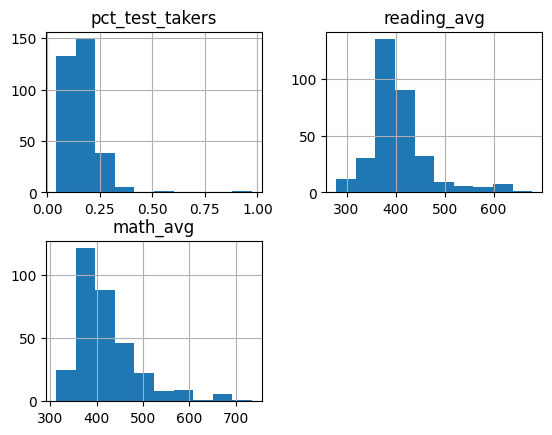

In [84]:
cols = ['pct_test_takers', 'reading_avg', 'math_avg']
df_with_pct[cols].hist()

Ok, so looking at the above, we can see certain outliers -- both positive and negative.  But it doesn't look like there are any non-sensible values (like negative numbers).  Still, it's worth exploring the outliers further.

Finally, another way to quickly see get a sense of our data is with the describe function.

In [85]:
df_with_pct[cols].describe()

,pct_test_takers,reading_avg,math_avg
count,327.000000,327.000000,327.000000
mean,0.160892,406.119266,421.611621
std,0.077814,60.504990,68.020515
min,0.041916,279.000000,312.000000
25%,0.118438,371.000000,378.000000
50%,0.151462,395.000000,402.000000
75%,0.190515,424.500000,446.500000
max,0.974170,679.000000,735.000000


Again, we can look to make sure the various values of our data appear to be what we expect.  

### One last thing

The last problem with this dataset, is that it's old.  Our data is from 2010, and so is probably not too representive of current performance.  So it's important to try to choose more recent data.  And if we have data from different time periods, it's important to plot say a distribution of the years or months of the data to make sure: 

1. We have data evenly distributed across say a series of weeks or months -- if that's expected 
2. We can just select data that's more recent

### Missing data - it's not all bad

So this brings us to how to handle our missing data.  Lots of times, missing data means that we need to throw out some -- but not all -- of our data, and change the scope of our conclusions.

For example, above, maybe we can only make conclusions about certain boroughs (where our data is more complete) but not others.  Or maybe we can only make conclusions about certain schools.  

For example, even with our missing data, we could still take a look at schools that perform exceptionally well (or poor) -- especially those where we have a large percentage of test takers.  
Even more interesting may be schools that over or underperform what we expect.  So even, if we are limited by our dataset, that doesn't mean it has nothing to offer us.  

### Summary

In this lesson, we talked about considering the representativeness of our data.  That is, if we're going to make inferences from our data -- does our data reflect the real world?

We saw that we can check for missing data by looking at how our data compares to what we know about the real world -- for example the number of schools per boro.  And then we also looked for signs within our dataset -- like the percentage of test takers.

From there, we also looked at the values of our data to detect missing or incorrect data.  We did this through the `isna()` function, plotting distributions of our data, and through the describe function. 

We also discussed the problem of missing data -- that it can bias our dataset.  This occurs when the data that is missing is different from the data that is present.  And that here, it can occur with reporting bias.  Finally, we said that one way to handle missing or poor data, is to focus on what data *is* more complete.  Or change the scope of our conclusions -- for example, by focusing on an individual school instead of a region.